In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.animation as animation
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import sys
import pickle
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [2]:
def load_files(files):
    s21s = []
    for i, file in enumerate(files):
        freqs, s21 = np.load(file)
        if np.amax(s21) > 0 and np.amin(s21) < 0:
            s21 -= np.amax(s21)
        s21s.append(s21)
    if len(files) == 1:
        s21s = s21s[0]
    return freqs, np.array(s21s)

def smooth_sweep(s21, sw, order):
    smooth_s21 = savgol_filter(s21, sw, order)
    return smooth_s21

def track_tones(s21, locs, limit=5):
    for i, loc in enumerate(locs):
        init_loc = copy(loc)
        prev = s21[loc-1]
        now = s21[loc]
        next = s21[loc+1]
        if next < now:
            while next < now:
                loc += 1
                prev = now
                now = next
                next = s21[loc+1]
        elif next > now:
            while prev < now:
                loc -= 1
                next = now
                now = prev
                prev = s21[loc-1]
        elif next >= now and prev <= now:
            print('At min: ', i)
        else:
            print('No min: ', i)
        if abs(loc - init_loc) <= limit:
            locs[i] = loc
        else:
            print('Too far: ', i)   
    _, unique_indices = np.unique(locs, return_index=True)
    unique_mask = np.zeros(locs.shape, dtype=bool)
    unique_mask[unique_indices] = True
    return locs, unique_mask

def readout_tones(tones, s21s, dark, smoothing_window, smoothing_order):
    smooth_dark = smooth_sweep(dark, smoothing_window, smoothing_order)
    nr_kids = len(tones)
    nr_scans = s21s.shape[0]
    ds21s = np.empty((nr_scans, nr_kids))
    for i, s21 in enumerate(s21s):
        smooth_s21 = smooth_sweep(s21, smoothing_window, smoothing_order)
        for j, tone in enumerate(tones):
            shift = 0
            while s21[tone-shift-1] < s21[tone-shift]:
                shift += 1
            # shift = int(np.argmin(s21[tone-5:tone+1][::-1]))
            dark_min = smooth_dark[tone]
            s21_min = smooth_s21[tone-shift]
            s21_at_dark = s21[tone]
            ds21s[i, j] = (s21_at_dark - dark_min) * (s21_min - dark_min) / -dark_min
    return ds21s

def get_pos(ds21s, mpp):
    nr_kids = ds21s.shape[1]
    pos = np.empty((nr_kids)) # f0, 
    pos[:] = np.nan
    maxproms = np.empty((nr_kids)) # f0, 
    maxproms[:] = np.nan
    secproms = np.empty((nr_kids)) # f0, 
    secproms[:] = np.nan
    doubles = []
    for i in range(nr_kids):
        ds21 = ds21s[:, i]
        y = medfilt(ds21, 3)
        x = np.arange(len(y))
        a, b = np.polyfit(x, y, 1)
        ds21 -= (a*x + b)
        ds21s[:, i] = ds21
        baseline = y - (a*x + b)
        argsort = np.argsort(ds21)
        argmax = argsort[-1]
        secargmax = argsort[-2]
        max = ds21[argmax]
        secmax = ds21[secargmax]
        mean = np.mean(baseline)
        noise = np.std(baseline)
        maxprom = 20*np.log10(max / noise)
        secprom =  20*np.log10(secmax / noise)
        pos[i] = argmax
        maxproms[i] = maxprom
        secproms[i] = secprom
        if secprom >= mpp: 
            if len(doubles):
                if doubles[-1] != i-1:
                    doubles.append(i)
                else:
                    doubles = doubles[:-1]
            else:
                doubles.append(i)
    print('Mean prominence: ', np.mean(maxproms))
    fig, ax = plt.subplot_mosaic('ab', figsize=(4,2))
    hist = ax['a'].hist(pos, bins=np.arange(ds21s.shape[0]+1), facecolor='tab:blue', edgecolor='w')
    ax['b'].axvline(mpp, c='r')
    # ax['a'].axhline(nr_rows, c='r')
    ax['b'].hist(maxproms, bins='auto', alpha=.7)
    ax['b'].hist(secproms, bins='auto', alpha=.7)
    print('total: ', np.sum(~np.isnan(pos)))
    print('nr doubles: ', len(doubles))
    return pos, maxproms, secproms, doubles

def add_kids(added, to_add):
    global rows, cols, maxproms, secproms, maxproms_cols, secproms_cols, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    added = np.array(added, dtype=int)
    to_add = np.array(to_add, dtype=int)
    secargmax_rows = np.argsort(ds21s_rows[:, to_add], axis=0)[-2, :]
    rows = np.insert(rows, to_add, secargmax_rows)
    ds21s_rows = np.insert(ds21s_rows, to_add, ds21s_rows[:, to_add], axis=1)
    secargmax_cols = np.argsort(ds21s_cols[:, to_add], axis=0)[-2, :]
    cols = np.insert(cols, to_add, secargmax_cols)
    ds21s_cols = np.insert(ds21s_cols, to_add, ds21s_cols[:, to_add], axis=1)
    maxproms = np.insert(maxproms, to_add, secproms[to_add])
    secproms = np.insert(secproms, to_add, maxproms[to_add])
    maxproms_cols = np.insert(maxproms_cols, to_add, secproms_cols[to_add])
    secproms_cols = np.insert(secproms_cols, to_add, maxproms_cols[to_add])
    f0s = np.insert(f0s, to_add, f0s[to_add])
    locs = np.insert(locs, to_add, locs[to_add])
    to_add = np.sort(to_add)
    to_add += np.arange(len(to_add))
    for kid in to_add:
        added[added >= kid] += 1
        added = np.hstack((added, kid, kid+1))
    return list(np.sort(added))

def del_kids(added, to_delete):
    global rows, cols, maxproms, secproms, maxproms_cols, secproms_cols, f0s, ds21s_rows, ds21s_cols, locs  # Declare global variables

    to_delete = np.sort(to_delete)
    to_delete = np.array(to_delete, dtype=int)
    added = np.array(added, dtype=int)
    
    rows = np.delete(rows, to_delete)
    cols = np.delete(cols, to_delete)
    maxproms = np.delete(maxproms, to_delete)
    secproms = np.delete(secproms, to_delete)
    maxproms_cols = np.delete(maxproms_cols, to_delete)
    secproms_cols = np.delete(secproms_cols, to_delete)
    f0s = np.delete(f0s, to_delete)
    ds21s_rows = np.delete(ds21s_rows, to_delete, axis=1)
    ds21s_cols = np.delete(ds21s_cols, to_delete, axis=1)
    locs = np.delete(locs, to_delete)
    for kid in to_delete[::-1]:
        if kid in added:
            added = np.delete(added, np.argwhere(added == kid))
        if kid-1 in added: 
            added = np.delete(added, np.argwhere(added == kid-1))
        elif kid+1 in added: 
            added = np.delete(added, np.argwhere(added == kid+1))
        added[added >= kid] -= 1
    return list(added)

def plot_dipshit(s21s, ds21s, pos, kids, steps=[], bw=50):
    global f0s, locs, freqs, avg_s21, smoothing_window, smoothing_order
    fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
    custom_colors = ['b', 'y', 'g', 'p']

    for kid in kids:
        ds21 = ds21s[:, kid]
        baseline = medfilt(ds21, 3)
        res = f0s[kid]
        loc = locs[kid]
        index = np.arange(loc-bw,loc+bw)
        hit = int(pos[kid])
        ax['b'].axhline(np.mean(baseline), ls='--', lw=1, c='k')
        ax['a'].plot(freqs[index], avg_s21[index], lw=2, label='dark', c='k')
        ax['a'].axvline(res, c='k', ls='--', lw=1)
        ax['a'].plot(freqs[index], smooth_sweep(s21s[hit, index], smoothing_window, smoothing_order), lw=2, label='hit @' + str(hit), c='r')
        ax['b'].axvline(hit, ls='--', lw=2, c='r')
        for i, step in enumerate(steps):
            ax['a'].plot(freqs[index], smooth_sweep(s21s[step, index], smoothing_window, smoothing_order), lw=1, label=str(step), c=custom_colors[i])
            ax['b'].axvline(step, ls='--', lw=1, c=custom_colors[i])
        ax['b'].plot(ds21, lw=2, label=str(kid), c='k')
    ax['b'].legend()
    ax['a'].legend()

def plot_rows(rows, doubles=[], too_close=[], lo=None):    
    global f0s, nr_cols, maxproms
    fig, ax = plt.subplot_mosaic('aaaab', figsize=(14,9), constrained_layout=True, sharey=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(f0s, rows, c=maxproms, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='vertical', location='left')
    cbar.set_label('Max Prominence')
    for id, row in enumerate(rows):
        ax['a'].annotate(id, (f0s[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(f0s[id], rows[id], marker='o', facecolor='None', edgecolor='cyan', linewidth=2)
    for id in too_close:
        ax['a'].scatter(f0s[id], rows[id], marker='o', facecolor='None', edgecolor='magenta', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_yticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axvline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', orientation='horizontal', label=['< LO', '> LO'], stacked=True)
        ax['b'].axvline(nr_cols/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w', orientation='horizontal')
    ax['b'].axvline(nr_cols, c='k', ls='-', lw=2)
    ax['b'].legend()

def plot_cols(rows, doubles=[], too_close=[], lo=None):    
    global f0s, nr_rows, maxproms_cols
    fig, ax = plt.subplot_mosaic('b;a;a;a;a', figsize=(9,14), constrained_layout=True, sharex=True)   
    custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
    custom_cmap = mpl.colors.ListedColormap(custom_colors)
    ax['a'].scatter(rows, f0s, c=maxproms_cols, cmap=custom_cmap)
    cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='horizontal', location='bottom')
    cbar.set_label('Max Prominence')
    for id, col in enumerate(rows):
        ax['a'].annotate(id, (col+.3, f0s[id]), fontsize=8, ha='center', va='center', rotation=-45)
    for id in doubles:
        ax['a'].scatter(rows[id], f0s[id], marker='o', facecolor='None', edgecolor='cyan', linewidth=2)
        # ax['a'].scatter(rows[id+1], f0s[id+1], marker='o', facecolor='None', edgecolor='cyan', linewidth=2)
    for id in too_close:
        ax['a'].scatter(rows[id], f0s[id], marker='o', facecolor='None', edgecolor='magenta', linewidth=2)
    min_pos = np.nanmin(rows)
    max_pos = np.nanmax(rows)
    binedges = np.arange(min_pos, max_pos+2, 1)
    ax['a'].set_xticks(binedges)
    hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
    if lo:
        ax['a'].axhline(lo, c='k', ls='-', lw=1)
        lo_mask = f0s < lo
        ax['b'].hist([rows[lo_mask], rows[~lo_mask]], bins=binedges-.5, edgecolor='w', label=['< LO', '> LO'], stacked=True)
        ax['b'].axhline(nr_rows/2, c='k', ls='-', lw=1)
    else:
        ax['b'].hist(rows, bins=binedges-.5, edgecolor='w')
    ax['b'].axhline(nr_rows, c='k', ls='-', lw=2)
    ax['b'].legend()

def map_kids(nans):
    global rows, nr_rows, nr_cols
    row_list = [[] for _ in range(nr_rows)]
    for id, row in enumerate(rows):
        if not np.isnan(row):
            row_list[int(row)].append(int(id))
    map_sorted = np.empty((nr_rows, nr_cols))
    map_sorted[:] = np.nan   
    for i, row in enumerate(row_list):
        map_sorted[i, :len(row)] = row
    for i, j in nans:
        map_sorted[i, j+1:] = map_sorted[i, j:-1]
        map_sorted[i, j] = np.nan
    return map_sorted

def roll_map(map, roll):
    for i, row in enumerate(map):
        map[i] = np.roll(row, i*roll)
    return map

def common_mode(x, y, deg):
    coeff = np.polyfit(x, y, deg)
    cmode = np.poly1d(coeff)
    print(cmode)
    return cmode

def comp_scatter(design, meas, deg, edges): 
    global kid_id_board

    nanmask = np.isnan(meas) + np.isnan(design) 
    if not edges:
        centermask = np.zeros_like(meas, dtype=bool)
        ids_center = kid_id_board[1:-1, :-1].flatten()
        centermask[ids_center] = True
        mask = ~nanmask & centermask
    else:
        mask = ~nanmask
    if deg:
        cmode = common_mode(design[mask], meas[mask], deg)
        design_fit = cmode(design)
    else:
        design_fit = design 
        cmode = None
    scatter = (meas - design_fit) / design_fit
    return scatter, cmode

def plot_scatter(deg=1, annotate=False, clim=[], edges=False):
    global design, meas, nanmask, kid_id_board, nr_rows, nr_cols, kids

    df_f, cmode = comp_scatter(design, meas, deg, edges)
    df_f_map = df_f[kid_id_board]
    flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])

    fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
    ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
    ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{meas}$')  
    if deg:
        xfit = np.linspace(flim[0], flim[1])
        yfit = cmode(xfit)
        ax['a'].plot(xfit, yfit, c='k', label='common mode, deg=%d' % (len(cmode.c)-1), ls='--', lw=0.5)
    ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
    ax['a'].set_xlim(flim)
    ax['a'].set_ylim(flim)
    ax['a'].legend(loc='upper left')
    if not len(clim):
        clim = [np.amin(df_f[~nanmask]), np.amax(df_f[~nanmask])]
    ax['b'].scatter(design, df_f, c=df_f, vmin=clim[0], vmax=clim[1], label='residual')
    ax['b'].annotate
    ax['b'].set_ylabel('$\it df*/f$')
    ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
    im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
    if annotate:
        for i, x in enumerate(df_f_map):
            for j, y in enumerate(x):
                if ~np.isnan(y):
                    old_id = kid_id_board[i, j]
                    new_id = kids[i, j]
                    if old_id == new_id:
                        c = 'w'
                    else:
                        c = 'r'
                    ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=6, color='w', rotation=45)
    # Major ticks
    ax['c'].set_xticks(np.arange(0, nr_cols, 1)-0.5, minor=False)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1)-0.5, minor=False)
    ax['c'].set_xticks(np.arange(0, nr_cols, 1), minor=True)
    ax['c'].set_yticks(np.arange(0, nr_rows, 1), minor=True)
    # Labels for major ticks
    ax['c'].set_xticklabels(np.arange(0, nr_cols, 1), minor=True, rotation=-90)
    ax['c'].set_yticklabels(np.arange(0, nr_rows, 1), minor=True, rotation=0)
    ax['c'].set_yticklabels([], minor=False)
    ax['c'].set_xticklabels([], minor=False)
    ax['c'].grid(which='major', linestyle='-', linewidth=0.5)
    ax['c'].grid(which='minor', visible=False)
    ax['c'].set_xlabel('$\it x$ $[px]$')
    ax['c'].set_ylabel('$\it y$ $[px]$')
    cbar = fig.colorbar(im, ax=ax['c'])
    _ = cbar.ax.set_ylabel('$\it df*/f$')

    scatter = np.std(df_f[~nanmask])
    pxl_yield = (np.sum(~np.isnan(meas))/(nr_rows*nr_cols))
    print('scatter = %.3f%%' % (scatter*1e2))
    print('yield = %.3f%%' % (pxl_yield*1e2))
    return df_f, df_f_map

def image(ds21s):
    global nr_rows, nr_cols

    nr_scans = ds21s.shape[0]
    maps = np.zeros((nr_rows, nr_cols, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    ds21s[:, k] -= np.amin(ds21s[:, k])
                    ds21s[:, k] /= np.amax(ds21s[:, k])
                    maps[i, j, nr] = ds21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps

def plot_image(map, annotate=True):
    global kids
    
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.imshow(map, origin='lower', cmap='viridis')
    M, N = map.shape
    for i, x in enumerate(kids):
        for j, y in enumerate(x):
                if ~np.isnan(y):
                    new_id = kids[i, j]
                    ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
    # Major ticks
    ax.set_xticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_yticks(np.arange(0, N, 1)-0.5, minor=False)
    ax.set_xticks(np.arange(0, M, 1), minor=True)
    ax.set_yticks(np.arange(0, M, 1), minor=True)
    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, N, 1), minor=True, rotation=0)
    ax.set_yticklabels(np.arange(0, M, 1), minor=True, rotation=0)
    ax.set_yticklabels([], minor=False)
    ax.set_xticklabels([], minor=False)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', visible=False)
    return fig, cax

def animate_image(maps, annotate=False, save=None):
    fig, cax = plot_image(maps[:,:, 0], annotate=annotate)
    nr_scans = maps.shape[2]
    def update(frame):
        cax.set_array(maps[:, :, frame])
        return cax,
    ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
    if save:
        ani.save(save, writer='Pillow')
    return ani

def rel_freqs(f0, f1, nr_kids):
    oct = np.log2(f1/f0)
    spacing = 2**(oct/(nr_kids-1))
    powers = np.arange(nr_kids)
    f0s = f0 * (spacing)**powers
    return f0s

def plot_dip(freqs, sweep):
    fig, ax = plt.subplots(figsize=(3,3))
    cax, = ax.plot(freqs, sweep, lw=1, c='b')
    return fig, cax

def plot_dip_with_slider(s21s, kid, bw=50):
    global dark_s21
    loc = locs[kid]
    nr_frames = s21s.shape[0] - 1
    index = np.arange(loc-bw, loc+bw)
    fig, cax = plot_dip(freqs[index], smooth_sweep(dark_s21[index], smoothing_window, smoothing_order))
    ax_slider = fig.add_axes([0.1, 0.01, 0.8, 0.03])  # Slider position
    slider = Slider(ax_slider, 'Frame', -1, nr_frames, valinit=0, valstep=1)

    def update(val):
        frame = int(slider.val)
        sweep = s21s[frame, index]
        cax.set_ydata(smooth_sweep(sweep, smoothing_window, smoothing_order))
        fig.canvas.draw_idle()

    slider.on_changed(update)
    return fig

In [3]:
# f, s21 = np.load(glob(dir + '*dark*.npy')[0])
# mux_array = np.empty((len(s21), 2))
# mux_array[:, 1] = s21
# mux_array[:, 0] = f
# print(mux_array)
# np.savetxt('LT402chip1_darksweep.txt', mux_array, delimiter=' ', fmt='%.8f %.8f')

In [4]:
master = {}
master['design'] = {}
dir  = r"C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\sonnet\LT402 Design/"
chip = 'LT402_20x20_5-7GHz'
path = dir + chip + '/'
with open('LT402chip1_master.pkl', 'rb') as f:
    master = pickle.load(f)
kid_id_board = np.load( path + chip + '_id.npy')

dir = '.\S21s_20251215_16h36/'
yfiles = natsorted(glob(dir + '*y*.npy'))
xfiles = natsorted(glob(dir + '*x*.npy'))
freqs, s21s_rows = load_files(yfiles)
s21s_cols = load_files(xfiles)[1]
avg_s21 = np.mean(np.vstack((s21s_rows)), axis=0)
_, dark_s21 = load_files([glob(dir + '*dark*.npy')[0]])

nr_rows = 20
nr_cols = 20
nr = nr_rows * nr_cols

Total:  397
Too close, within 0.1 MHz:  4 , ids:  [125, 126, 258, 259]
Overlapping:  0 , ids:  []


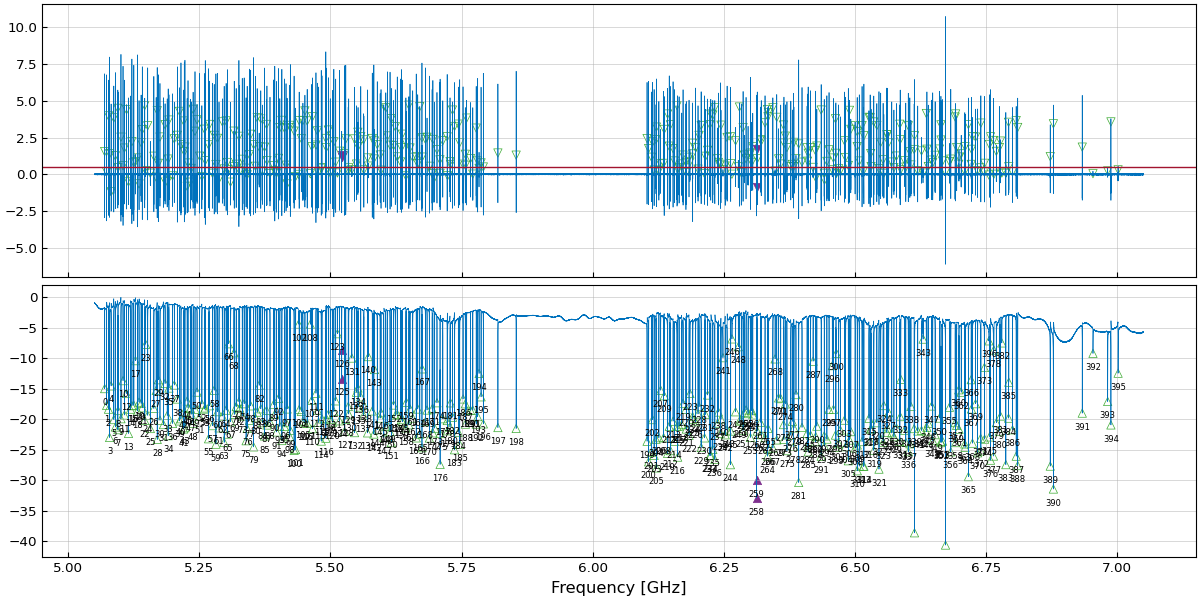

In [5]:
mph = .5
min_df = .1
smoothing_window = 2
smoothing_order = 0
smoothed_dark = smooth_sweep(dark_s21, smoothing_window, smoothing_order)
ds21 = np.diff(smoothed_dark)
smoothed_ds21 = smooth_sweep(ds21, smoothing_window, smoothing_order)
d2s21 = np.diff(smoothed_ds21)

s21 = -(dark_s21-np.amax(dark_s21))
init_locs, props = find_peaks(s21, height=0, prominence=2)
init_locs = np.hstack((init_locs, 109160))
init_locs = np.delete(init_locs, -7)

heights = d2s21[init_locs-1]
# init_locs += 1
init_locs, unique_mask = track_tones(smoothed_dark, init_locs)
# unique_mask[414] = 0

init_f0s = freqs[init_locs]
s21_mins = smoothed_dark[init_locs]

# BEGIN:
too_close_mask = np.zeros(init_f0s.shape, dtype=bool)
for i in range(len(init_f0s) - 1):
    if np.abs(init_f0s[i] - init_f0s[i + 1]) < min_df*1e-3 and (unique_mask[i] and unique_mask[i + 1]):
        too_close_mask[i + 1] = True
        too_close_mask[i] = True

        # if s21_mins[i] < s21_mins[i + 1]:
        #     too_close_mask[i + 1] = True
        # else:
        #     too_close_mask[i] = True

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smoothed_dark, lw=.5)
ax['a'].axhline(mph, c='r')
mask = ~too_close_mask & unique_mask
ax['a'].scatter(freqs[init_locs[mask]-1], heights[mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(init_f0s[mask], s21_mins[mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[init_locs[too_close_mask]], heights[too_close_mask], marker='v', c='p', edgecolor='p')
ax['b'].scatter(init_f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='p', edgecolor='p')
ax['a'].scatter(freqs[init_locs[~unique_mask]], heights[~unique_mask], marker='v', c='r', edgecolor='r')
ax['b'].scatter(init_f0s[~unique_mask], s21_mins[~unique_mask], marker='^', c='r', edgecolor='r')
for i, loc in enumerate(init_locs):
    ax['b'].annotate(f'{i}', (init_f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(init_locs))
too_close = np.argwhere(too_close_mask).flatten().tolist()
unique = np.argwhere(~unique_mask).flatten().tolist()
print('Too close, within', min_df, 'MHz: ', len(init_locs[too_close_mask]), ', ids: ', too_close)
print('Overlapping: ', len(init_locs[~unique_mask]), ', ids: ', unique)

Mean prominence:  35.57741763056179
total:  397
nr doubles:  10
doubles:  [25, 126, 143, 270, 333, 340, 354, 366, 373, 396]
too_close:  [125, 126, 258, 259]
not unique:  []
Mean prominence:  40.99795076308895
total:  397
nr doubles:  15


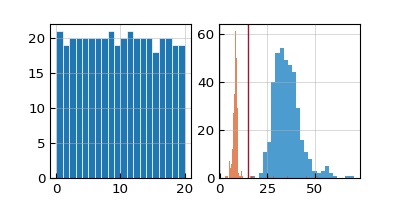

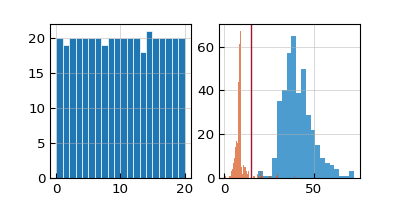

In [6]:
mask = unique_mask
mask = np.ones(init_locs.shape, dtype=bool)
locs = init_locs[mask]
f0s = init_f0s[mask]

ds21s_rows = readout_tones(locs, s21s_rows, dark_s21, smoothing_window, smoothing_order)
ds21s_cols = readout_tones(locs, s21s_cols, dark_s21, smoothing_window, smoothing_order)

mpp = 15
rows, maxproms, secproms, doubles = get_pos(ds21s_rows, mpp)
print('doubles: ', doubles)
print('too_close: ',too_close)
print('not unique: ',unique)
doubles = [25]
cols, maxproms_cols, secproms_cols, xdoubles = get_pos(ds21s_cols, mpp)

doubles = add_kids([], doubles)
rows[397] = 18
doubles = del_kids(doubles, [127])
rows[343] = 9
doubles = del_kids(doubles, [274])
# doubles = del_kids(doubles, [393])


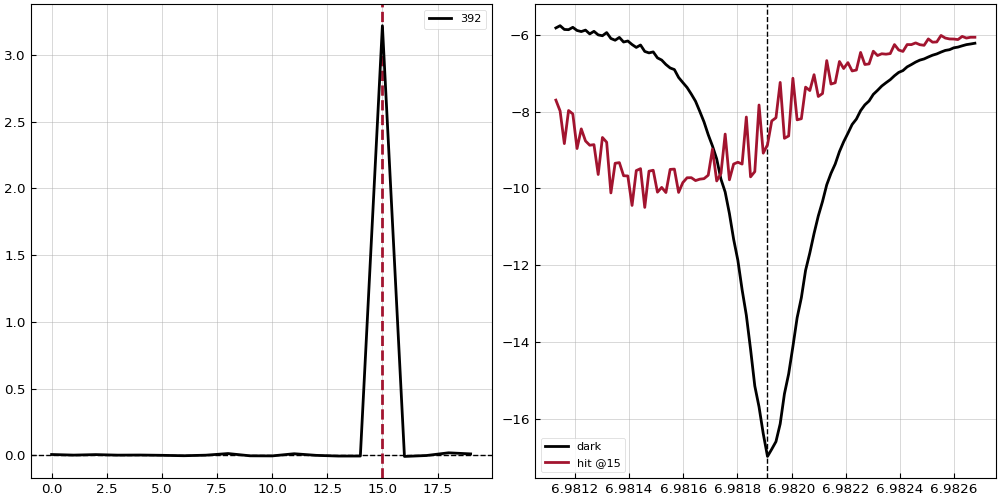

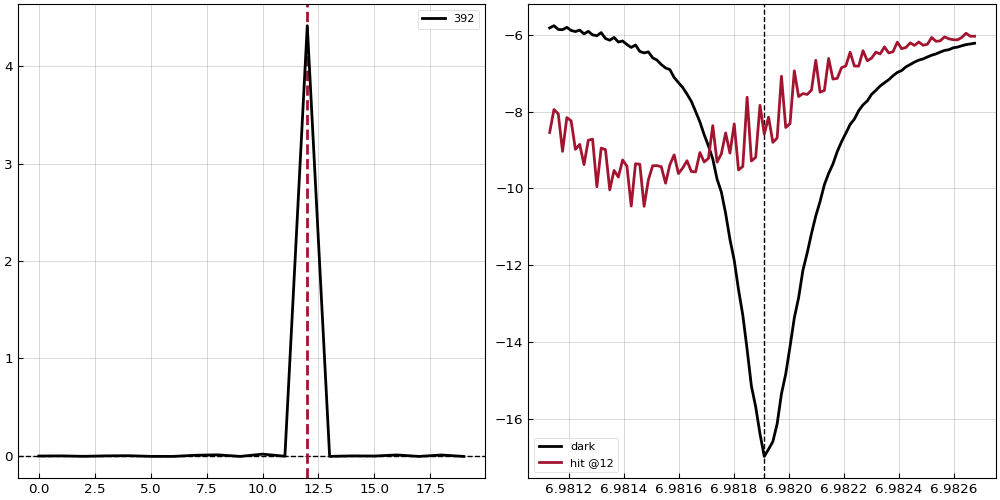

In [7]:
kid = 392
# 1014, 1002, 999, 923, 886, 882, 688, (884), 814, 799, 722, (746), 741, 926
plot_dipshit(s21s_rows, ds21s_rows, rows, [kid], [])
plot_dipshit(s21s_cols, ds21s_cols, cols, [kid], [])


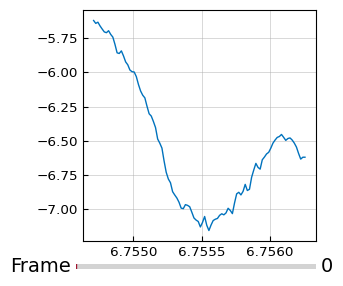

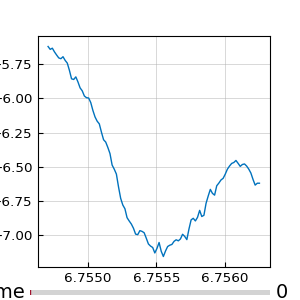

In [8]:
from matplotlib.widgets import Slider

def plot_dip(freqs, sweep):
    fig, ax = plt.subplots(figsize=(3,3))
    cax, = ax.plot(freqs, sweep, lw=1, c='b')
    return fig, cax

def plot_dip_with_slider(s21s, kid, bw=50):
    loc = locs[kid]
    index = np.arange(loc-bw, loc+bw)
    fig, cax = plot_dip(freqs[index], smooth_sweep(dark_s21[index], smoothing_window, smoothing_order))
    ax_slider = fig.add_axes([0.1, 0.01, 0.8, 0.03])  # Slider position
    slider = Slider(ax_slider, 'Frame', 0, 19, valinit=0, valstep=1)

    def update(val):
        frame = int(slider.val)
        sweep = s21s[frame, index]
        cax.set_ydata(smooth_sweep(sweep, smoothing_window, smoothing_order))
        fig.canvas.draw_idle()

    slider.on_changed(update)
    return fig

plot_dip_with_slider(s21s_rows, 395)


In [ ]:
plot_rows(rows, doubles, lo=6)

In [ ]:
plot_cols(cols, doubles, lo=6)

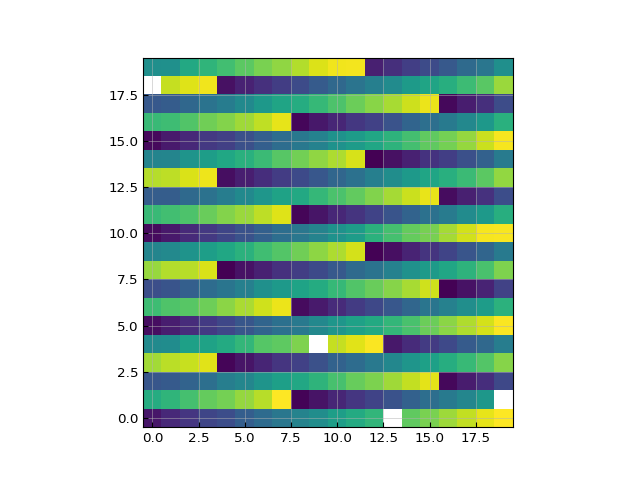

In [9]:
nans = [[1, 16],
        [15, 0], [15, 17],
        [18, 11],
        [19, 13]]

map = map_kids(nans)
kids = roll_map(np.flip(map, axis=0), 8)
kids[4, 12] = 392
fig, ax = plt.subplots()
ax.imshow(kids, origin='lower', cmap='viridis')

In [10]:
swaps = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
[a, b] = [0, -1]
for row in swaps:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]
swaps = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 16, 18]
[a, b] = [1, -1]
for row in swaps:
    kids[row, a], kids[row, b] = kids[row, b], kids[row, a]
kids[10, 13:19] = kids[10, 12:18]
kids[10, 12] = 389

In [ ]:
kids2 = np.empty((nr_rows, nr_cols))
kids2[:] = np.nan
for i in range(len(rows)):
    row = int(rows[i])
    col = int(cols[i])
    kid = kids2[row, col]
    if np.isnan(kid):
        kids2[row, col] = i
    else:
        if i in doubles:
            kids2[row, col] = -2000
        else:
            kids2[row, col] = -1000
kids2 = np.flip(kids2, axis=0)
# kids2[np.isnan(kids)] = 2000
fig, ax = plt.subplots()
_ = ax.imshow(kids2, cmap='viridis', origin='lower', vmin=-2000, vmax=2000)


In [ ]:
fig, ax = plt.subplot_mosaic('abcd', figsize=(12,3), constrained_layout=True)
diff_kids = kids-kids2
ax['a'].imshow(kids, cmap='viridis', origin='lower')
ax['a'].set_title('row map')
ax['b'].imshow(kids2, cmap='viridis', origin='lower')
ax['b'].set_title('row+col map')
ax['c'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['c'].set_title('difference map')

# kids[7] = kids2[7]

diff_kids = kids-kids2
ax['d'].imshow(diff_kids, cmap='viridis', origin='lower', vmin=-1, vmax=1)
ax['d'].set_title('corrected map')


In [11]:
finger_lengths = master['trimdesign']['fingers']
design_f0s = master['lensmeasured']['f0']
master['lensmeasured 2'] = {}
master['lensmeasured 2']['f0'] = np.empty(nr_rows*nr_cols)
master['lensmeasured 2']['f0'][:] = np.nan
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master['lensmeasured 2']['f0'][idx] = meas_f
design = master['lensmeasured']['f0']
meas = master['lensmeasured 2']['f0']
nanmask = np.isnan(meas) + np.isnan(design)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)

scatter = 0.025%
yield = 99.000%


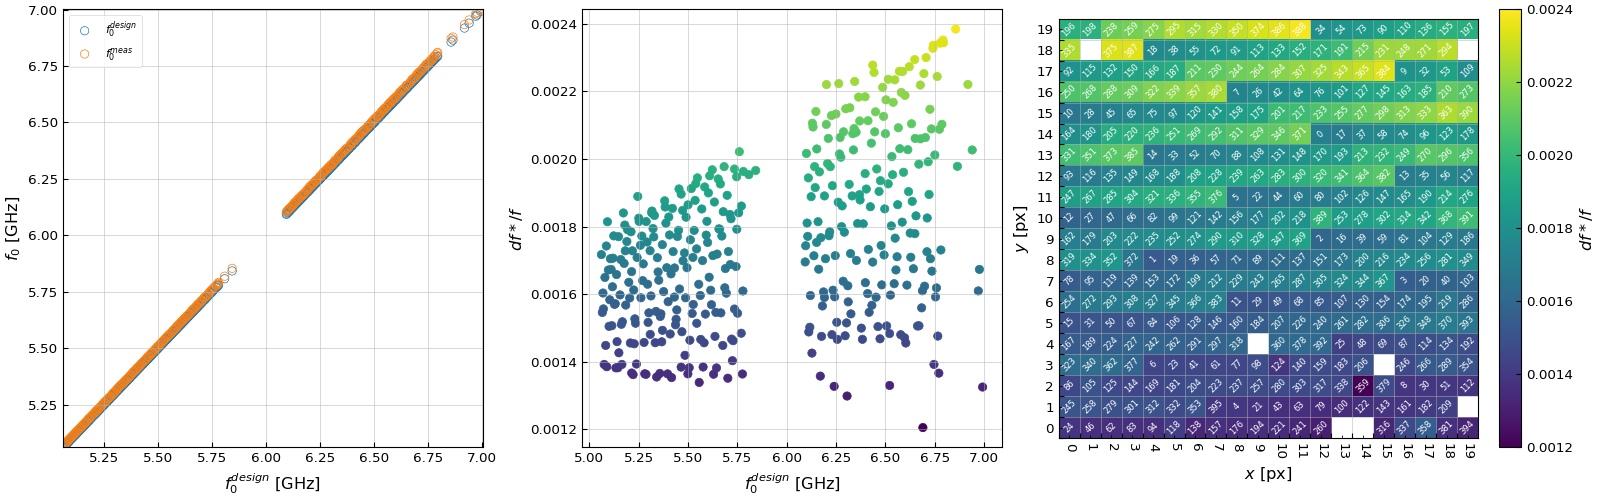

In [12]:
df_f, df_f_map = plot_scatter(0, annotate=True, clim=[0.0012, 0.0024], edges=True)

In [ ]:
mux_array = np.empty((nr_rows*nr_cols, 3))
mux_array[:, 0] = master['design']['row']
mux_array[:, 1] = master['design']['col']
mux_array[:, 2] = master['lensmeasured 2']['f0']
print(mux_array)
# np.savetxt('LT402chip1_20251215_trimmed_lenses.txt', mux_array, delimiter=' ', fmt='%d %d %1.4f')

In [ ]:
fig, ax = plt.subplots()
ax.plot(master['design']['f0'], 'o ')
ax.plot(master['measured']['f0'], 'o ')
ax.plot(master['trimmeasured']['f0'], 'o ')
ax.plot(master['lensmeasured']['f0'], 'o ')
ax.plot(master['lensmeasured 2']['f0'], 'o ')

In [ ]:
np.nanmin(mux_array[:, 2])

In [ ]:
np.nanstd(df_f)

In [23]:
# with open('LT402chip1_master.pkl', 'wb') as f:
#     pickle.dump(master, f)

In [20]:
def find_yield(f0s, Q, threshold):
    diffs = np.diff(f0s)
    fwhms = f0s / Q
    rel_diffs = diffs/fwhms[:-1]
    too_close = rel_diffs<threshold
    good = np.ones(f0s.shape)
    good[1:] -= too_close
    good[:-1] -= too_close
    spaced = np.sum(good==True)
    total = len(f0s)

    return rel_diffs, spaced/total

In [ ]:
labels = ['measured', 'trimmeasured', 'lensmeasured']
fig, ax = plt.subplots()
for label in labels:
    f0s = master[label]['f0']
    nanmask = np.isnan(f0s)
    df, y = find_yield(np.sort(f0s[~nanmask]), 30e3, 4)
    ax.hist(df, bins='auto', alpha=0.75, label='%s: %.1f%%' % (label, y*100))
ax.axvline(4, c='r', label='threshold')
ax.set_xlabel('df / FWHM')
ax.set_ylabel('Counts')
ax.set_xlim(0, 100)
ax.legend()

In [346]:
maps = image(ds21s_rows)

In [ ]:
_ = plot_image(maps[:,:, 1])

In [ ]:
anim = animate_image(maps)
plt.show()